In [33]:
import numpy as np
from cmeutils.sampling import is_equilibrated, equil_sample
from cmeutils.structure import (
    gsd_rdf,
    structure_factor,
    diffraction_pattern,
    get_quaternions,
#    #nematic_order_parameter
)
#from cmeutils.polymers import get_bond_vectors

import unyt as u
from unyt import Unit
import signac
import gsd.hoomd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import freud
import rowan

import os
import grits
import mbuild as mb
import ele
import matplotlib

conv_dict = {
    "ca": ele.element_from_symbol("C"),
    "s": ele.element_from_symbol("S"),
    "sh": ele.element_from_symbol("S"),
}

In [2]:
# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
symbol_dict = {1.0: "o", 0.8: "s", 0.7: "^", 0.6: "d"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 1
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["legend.markerscale"] = 3

colors = [
    "#FF5733",  # Vermilion
    "#FFC300",  # Saffron
    "#4B0082",  # Indigo
    "#00A86B",  # Jade
    "#007FFF",  # Azure
    "#D2691E",  # Chocolate
    "#FF4500",  # Orange Red
    "#6A0DAD",  # Purple
    "#2E8B57",  # Sea Green
    "#FF6EC7",  # Blush Pink
    "#800080",  # Purple
    "#4682B4",  # Steel Blue
    "#008B8B",  # Dark Cyan
    "#E9967A",  # Dark Salmon
    "#FFD700",  # Gold
    "#800000",  # Maroon 
]

def get_bond_vectors(snapshot, bond_type_filter=None):
    """Get all normalized bond vectors of a certain bond type.

    Parameters
    ---------
    snapshot : gsd.hoomd.Frame, required
        Frame of the GSD trajectory file to use
    bond_types : list-like, required
        List of bond types to find bond vectors
        Choose from options found in gsd.hoomd.Frame.bonds.types

    Returns
    ------
    vectors : List of arrays (shape=(1,3)
        List of all normalized bond vectors matching bond_types

    """
    if not bond_type_filter:
        bond_type_filter = snapshot.bonds.types
    vectors = []
    for bond in bond_type_filter:
        if bond not in snapshot.bonds.types:
            raise ValueError(
                f"Bond type {bond} not found in snapshot.bonds.types"
            )
        bond_id = snapshot.bonds.types.index(bond)
        bond_indices = np.where(snapshot.bonds.typeid == bond_id)[0]
        for i in bond_indices:
            bond_group = snapshot.bonds.group[i]
            p1 = snapshot.particles.position[bond_group[0]]
            p2 = snapshot.particles.position[bond_group[1]]
            vectors.append((p2 - p1) / np.linalg.norm(p2 - p1))
    return vectors

def generate_color_gradient(start_color, end_color, num_steps):
    """Generate a gradient of colors between two given colors.

    Parameters:
    - start_color: Starting color in RGB format (e.g., [r, g, b])
    - end_color: Ending color in RGB format (e.g., [r, g, b])
    - num_steps: Number of steps in the gradient

    Returns:
    - colors: List of color codes representing the gradient
    """
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [start_color, end_color])
    norm = mcolors.Normalize(vmin=0, vmax=num_steps-1)
    colors = [cmap(norm(i)) for i in range(num_steps)]
    return colors


def nematic_order_parameter(vectors, director):
    """Finds the nematic (S2) order parameter for a list of vectors
    Parameters
    ----------
    vectors : sequence of vectors; required
        The list of vectors to use in the nematic order parameter calculation
    director : numpy.ndarray, shape=(1,3)
        The nematic director of the reference state

    Returns
    -------
    freud.order.Nematic
    """
    vectors = np.asarray(vectors)
    orientations = rowan.normalize(
        np.append(np.zeros((vectors.shape[0], 1)), vectors, axis=1)
    )
    nematic = freud.order.Nematic(np.asarray(director))
    nematic.compute(orientations)
    return nematic
    

def kT_to_T(kT, epsilon):
    """kT converted to C"""
    return ((kT*epsilon)/8.31446262) - 273.15


def k_vector_to_2theta(k, wave_length):
    """"""
    d = 2*np.pi / k
    return 2 * np.arcsin(wave_length/(2*d))


def k_vector_to_distance(k):
    return (2 * np.pi) / k

In [3]:
project = signac.get_project("../validation")
#project = signac.get_project("../training-runs/low-density-states/")

In [ ]:
def append_first_frame(job):
    fpath = job.fn(f"trajectory-nvt{job.doc.nvt_runs-1}.gsd")

    with gsd.hoomd.open(job.fn("combined-nvt.gsd"), "w") as new_traj:
        with gsd.hoomd.open(job.fn("trajectory-npt0.gsd"), "r") as init_traj:
            new_traj.append(init_traj[0])
        with gsd.hoomd.open(fpath) as nvt_traj:
            for frame in nvt_traj:
                new_traj.append(frame)

def append_first_frame_npt(job):
    #if job.doc.npt_runs < 2:
    run = int(job.doc.npt_runs - 1)
    #else:
    #    run = int(job.doc.npt_runs - 2)
    print(run)
    fpath = job.fn(f"trajectory-npt{run}.gsd")
    print(fpath)
    with gsd.hoomd.open(job.fn("combined-npt.gsd"), "w") as new_traj:
        with gsd.hoomd.open(job.fn("trajectory-npt0.gsd"), "r") as init_traj:
            new_traj.append(init_traj[0])
        with gsd.hoomd.open(fpath) as nvt_traj:
            for frame in nvt_traj:
                new_traj.append(frame)

# Corase-grain the trajectories:

In [ ]:
def coarse_grain_last_npt(job):
    run = job.doc.npt_runs - 1
    fpath = job.fn(f"trajectory-npt{run}.gsd")
    with gsd.hoomd.open(job.fn("temp-npt.gsd"), "w") as temp_traj: # Delete this traj after CGing
        with gsd.hoomd.open(fpath, "r") as last_traj:
            with gsd.hoomd.open(job.fn("trajectory-npt0.gsd"), "r") as init_traj:
                temp_traj.append(init_traj[0])
                for frame in last_traj:
                    temp_traj.append(frame)

    bead_mapping = {"A": "c1ccc(S)cc1"}
    
    cg_system = grits.coarsegrain.CG_System(
        gsdfile=job.fn("temp-npt.gsd"),
        beads=bead_mapping,
        add_hydrogens=job.sp.remove_hydrogens,
        length_scale=job.doc.ref_length,
        mass_scale=job.doc.ref_mass,
        conversion_dict=conv_dict
    )
    
    cg_system.save(job.fn("last-npt-cg.gsd"), add_images=False, stride=50)
    os.remove(job.fn("temp-npt.gsd"))

In [ ]:
for job in project.find_jobs({"doc.npt_equilibrated": False, "sigma_scale": 0.955}):
    print(job.sp.kT, job.sp.sigma_scale, job.path)
    #job.doc.avg_density = den_dict[job.sp.kT]
    #job.doc.skip_npt_equil = True

In [ ]:
for job in project.find_jobs({"doc.npt_equilibrated": False, "sigma_scale": 0.955}):
    print(job.sp.kT, job.sp.sigma_scale, job.path)
    coarse_grain_last_npt(job)

In [ ]:
test_job = project.open_job(id="e6e236135ac867add24f9d4d31ee2741")

In [ ]:
bead_mapping = {"A": "c1ccc(S)cc1"}
for job in project:
    cg_system = grits.coarsegrain.CG_System(
        gsdfile=job.fn("trajectory.gsd"),
        beads=bead_mapping,
        add_hydrogens=job.sp.remove_hydrogens,
        length_scale=job.doc.ref_length,
        mass_scale=job.doc.ref_mass,
        conversion_dict=conv_dict
    )
    cg_system.save(job.fn("target-1monomer-per-bead.gsd"))

In [ ]:
grits.__path__

In [ ]:
for kT, jobs in project.find_jobs({"doc.nvt_equilibrated": True}).groupby("kT"):
    for job in jobs:
        if job.isfile("cg-nvt.gsd"):
            continue
        print(job.id)
        append_first_frame(job)
        fpath = job.fn("combined-nvt.gsd")
        bead_mapping = {"A": "c1ccc(S)cc1"}
        cg_system = grits.coarsegrain.CG_System(
            gsdfile=fpath,
            beads=bead_mapping,
            add_hydrogens=job.sp.remove_hydrogens,
            conversion_dict=conv_dict
        )
        cg_system.save(job.fn("cg-nvt.gsd"))
        print()

In [ ]:
for kT, jobs in project.find_jobs().groupby("kT"):
    for job in jobs:
        if job.isfile("cg-npt.gsd"):
            continue
        print(job.id)
        append_first_frame(job)
        fpath = job.fn("combined-npt.gsd")
        bead_mapping = {"A": "c1ccc(S)cc1"}
        cg_system = grits.coarsegrain.CG_System(
            gsdfile=fpath,
            beads=bead_mapping,
            add_hydrogens=job.sp.remove_hydrogens,
            conversion_dict=conv_dict
        )
        cg_system.save(job.fn("cg-npt.gsd"))
        print()

# Order Parameters:

In [ ]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    "doc.npt_equilibrated": True,
    "doc.nvt_equilibrated": True,
    "sigma_scale": 0.955
}

for job in project.find_jobs(filter=job_filter):
    if job.sp.kT < 2.4: continue
    print(job.sp.kT, job.id)
    run = job.doc.npt_runs - 1
    nem_orders = []
    with gsd.hoomd.open(job.fn("target_1monomer_per_bead.gsd"), "r") as traj:
        for snap in traj[0:-1:10]:
            bond_vectors = get_bond_vectors(snap, bond_type_filter=["A-A"])
            _nem_orders = []
            for director in [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 1)]:
                nem = nematic_order_parameter(vectors=bond_vectors, director=director)
                _nem_orders.append(nem.order)
            nem_orders.append(np.max(_nem_orders))
    print(len(nem_orders))
    job.doc.avg_nem = np.mean(nem_orders)
    job.doc.nem_std = np.std(nem_orders)

In [ ]:
kT_to_T(2.2887, epsilon=1065)

In [ ]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    #"kT": 3.0,
    #"doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}
fig = plt.figure()
temps = []
reduced_temps = []
avg_nems = []
std_nems = []
for kT, job in project.find_jobs(filter=job_filter).groupby("kT"):
    job = list(job)[0]
    T = kT_to_T(job.sp.kT, epsilon=1065)
    print(job.id, kT, T)
    if job.sp.kT < 2.4: continue
    try:
        T = kT_to_T(job.sp.kT, epsilon=1065)
        temps.append(T)
        reduced_temps.append(kT)
        avg_nems.append(job.doc.avg_nem)
        std_nems.append(job.doc.nem_std)
        #plt.errorbar(x=T, y=job.doc.avg_nem, yerr=job.doc.nem_std, marker="o", color="k")
    except:
        pass
        
#plt.vlines(x=(358.15-273.15), ymin=0.2, ymax=0.7, label="Tg", linestyle="--", color="r")
#plt.vlines(x=(135), ymin=0.2, ymax=0.7, label="Tc Range", linestyle="--", color="orange")
#plt.vlines(x=110.6, ymin=0.2, ymax=0.7, label=None, linestyle="--", color="orange")
#plt.vlines(x=(553.15-273.15), ymin=0.2, ymax=0.7, label="Tm", linestyle="--", color="g")
#plt.errorbar(x=temps, y=avg_nems, yerr=std_nems, marker="o", color="k", linestyle="")
plt.errorbar(x=reduced_temps, y=avg_nems, yerr=std_nems, marker="o", color="k", linestyle="")

plt.ylim(0.2, 0.8)
plt.legend()
plt.xlabel("T (C)")
plt.ylabel("< S2 >")
plt.show()

# Radial Distribution Functions:

In [ ]:
for kT, jobs in project.find_jobs({"sigma_scale": 0.955, "doc.nvt_equilibrated": True}).groupby("kT"):
    for job in jobs:
        if job.sp.kT < 2.4:
            continue
        print(kT, job.id)
        #if job.isfile("cg_rdf.txt"):
        #    continue
        fpath = job.fn("target_1monomer_per_bead.gsd")
        rdf, N = gsd_rdf(gsdfile=fpath, start=-50, stop=-1, A_name="A", B_name="A", r_max=6, exclude_bonded=True)
        save_data = np.vstack([rdf.bin_centers, rdf.rdf]).T
        np.savetxt(job.fn("cg_rdf.txt"), save_data)
        print(kT)

## Plot RDFs:

In [ ]:
count = 0

job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    "doc.npt_equilibrated": True,
    "sigma_scale": 0.955
}

state_jobs = [
    "1cbc57c38be8cfe0ae9994bcb19467e2",
    "73e2a18dd6e440ba0066c934fcb829e0",
    "39edcdb395b6b0d3c3028c6feb7547af",
    "212e36add95bb5744b05aa8ce8d29449",
    "9a2350bfd349debae443b6dd5f1beb2f",
    "d4f337da0a7ee79a1778c858471aa917",
    "100888a4bbe8114d13b7c682ba77a678"
]

colors = generate_color_gradient(start_color="blue", end_color="red", num_steps=len(state_jobs))

for kT, jobs in project.find_jobs(job_filter).groupby("kT"):
    for job in jobs:
        #if job.sp.kT < 2.4:
        #    continue
        if not job.isfile("cg_rdf.txt"):
            continue
        if job.id not in state_jobs:
            continue
        data = np.loadtxt(job.fn("cg_rdf.txt"))
        plt.plot(
            data[:,0] * job.doc.ref_length, data[:,1] + count * 0.00,
            label=kT,
            c=colors[count]
        )
        count += 1

plt.legend(title="Temp (C)")
plt.ylabel("g(r)")
plt.xlabel("r (nm)")

### Plot RDFs at entire temp range:









34.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/9142f5e776ff060fb7edb01495a9a86e

47.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/1cbc57c38be8cfe0ae9994bcb19467e2

60.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/a5250cea52a262d308592249ce463d10

73.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/393a1cc581d5324e470714d7c681dcac

86.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/51e475756aeadda668351a024760dcda

98.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/9a2350bfd349debae443b6dd5f1beb2f

111.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/73e2a18dd6e440ba0066c934fcb829e0

124.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/100888a4bbe8114d13b7c682ba77a678

137.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/d4f337da0a7ee79a1778c858471aa917

162.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/39edcdb395b6

Text(0.5, 0, 'r (nm)')

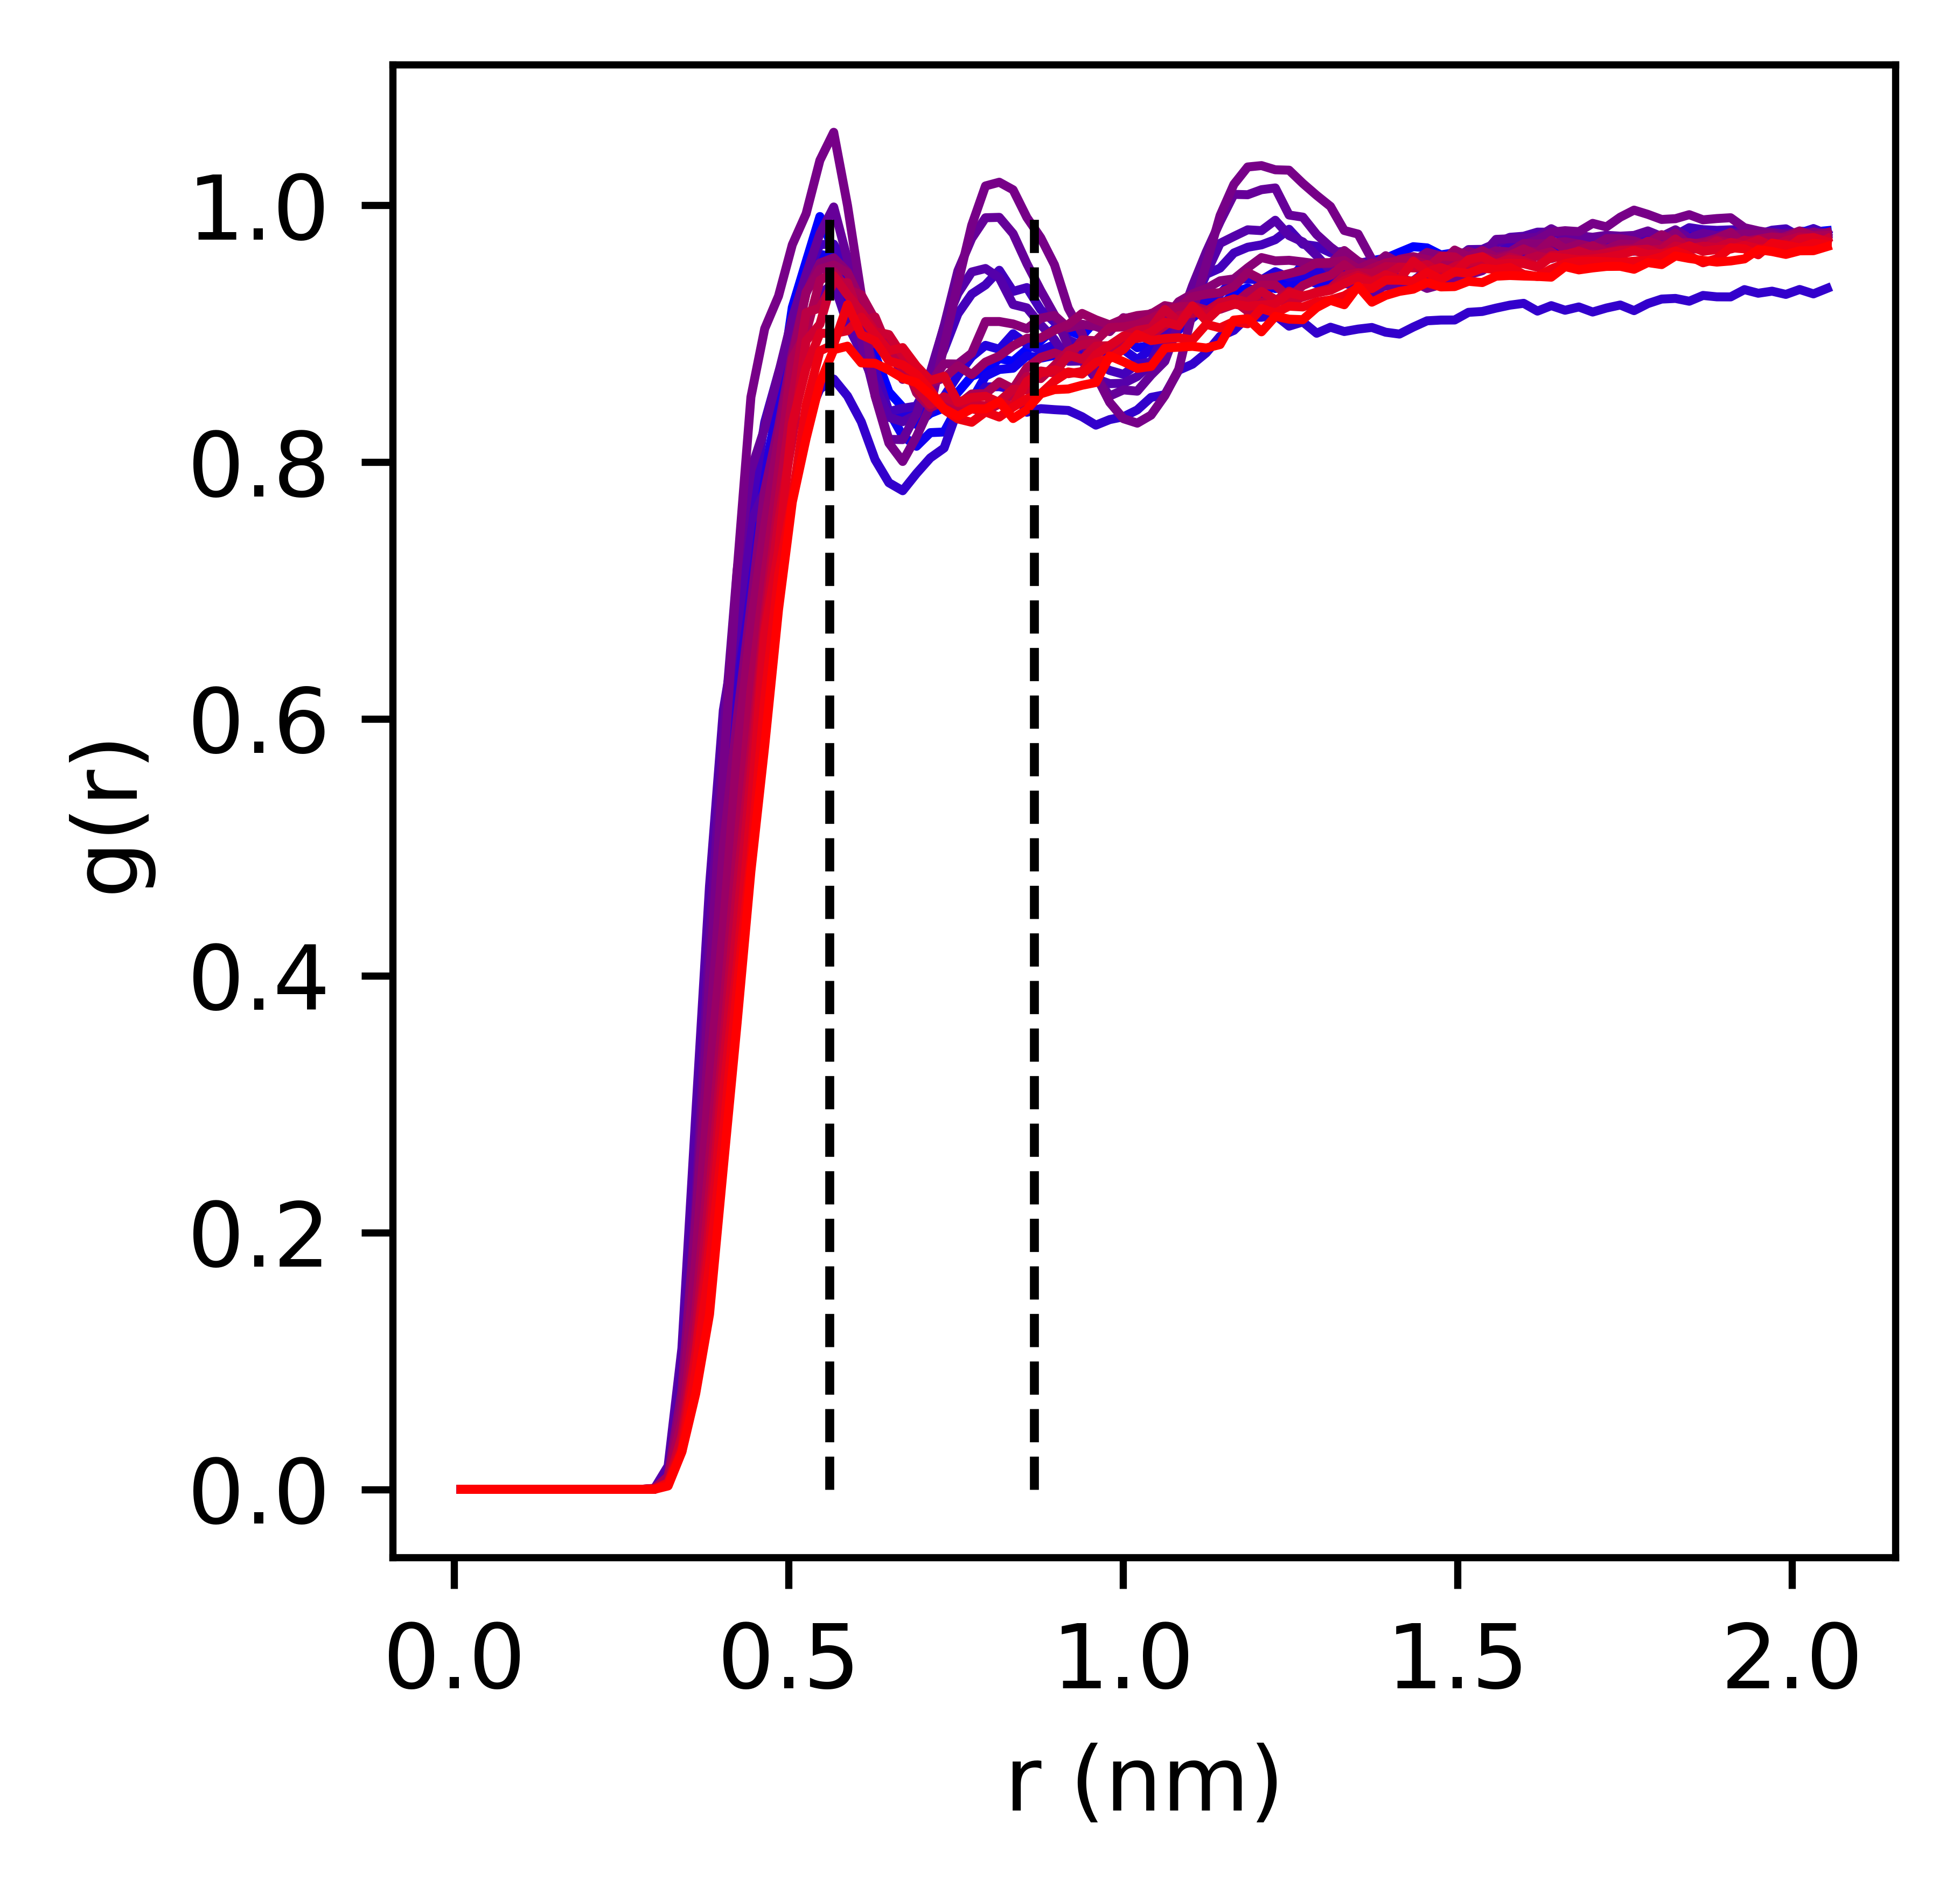

In [22]:
count = 0
colors = generate_color_gradient(start_color="blue", end_color="red", num_steps=16)

job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    #"kT": 3.0,
    #"doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}

for kT, jobs in project.find_jobs(job_filter).groupby("kT"):
    for job in jobs:
        print()
        if not job.isfile("cg_rdf.txt"):
            continue
        if job.sp.kT < 2.4: continue
        print(np.round(kT_to_T(job.sp.kT, epsilon=1065), 0))
        print(job.path)
        data = np.loadtxt(job.fn("cg_rdf.txt"))
        plt.plot(
            data[:,0] * job.doc.ref_length, data[:,1] + count * 0.00,
            label=np.round(kT_to_T(job.sp.kT, epsilon=1065), 0),
            c=colors[count]
        )
        count += 1

plt.vlines(x=0.561, ymin=0, ymax=1.0, linestyles="--", colors="black", label="0.561 nm")
#plt.vlines(x=0.516, ymin=0, ymax=1.0, linestyles="--", colors="r")
plt.vlines(x=0.867, ymin=0, ymax=1.0, linestyles="--", colors="black", label="0.867 nm")
#plt.legend(title="Temp (C)")
plt.ylabel("g(r)")
plt.xlabel("r (nm)")

# Structure Factors:

In [25]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    #"kT": 3.0,
    #"doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}

count = 0
job_id = "73e2a18dd6e440ba0066c934fcb829e0"
for kT, jobs in project.find_jobs(job_filter).groupby("kT"):
    if kT < 2.4: continue
    for job in jobs:
        if job_id:
            if job.id != job_id:
                continue
        #if job.isfile("cg_sf.txt"):
        #    continue
        fpath = job.fn("target_1monomer_per_bead.gsd")
        fpath = job.fn("trajectory-nvt0.gsd")
        sf = structure_factor(
            gsdfile=fpath,
            k_min=0.01,
            k_max=12,
            start=-10,
            stop=-1,
            ref_length=job.doc.ref_length,
            bins=50
        )
        x = sf.bin_centers
        y = sf.S_k
        save_data = np.vstack([x, y]).T
        np.savetxt(job.fn("cg_sf.txt"), save_data)
        #plt.plot(x, y+(count*0.25), label=kT, c=colors[count])
        count += 1

#plt.legend(loc="right")

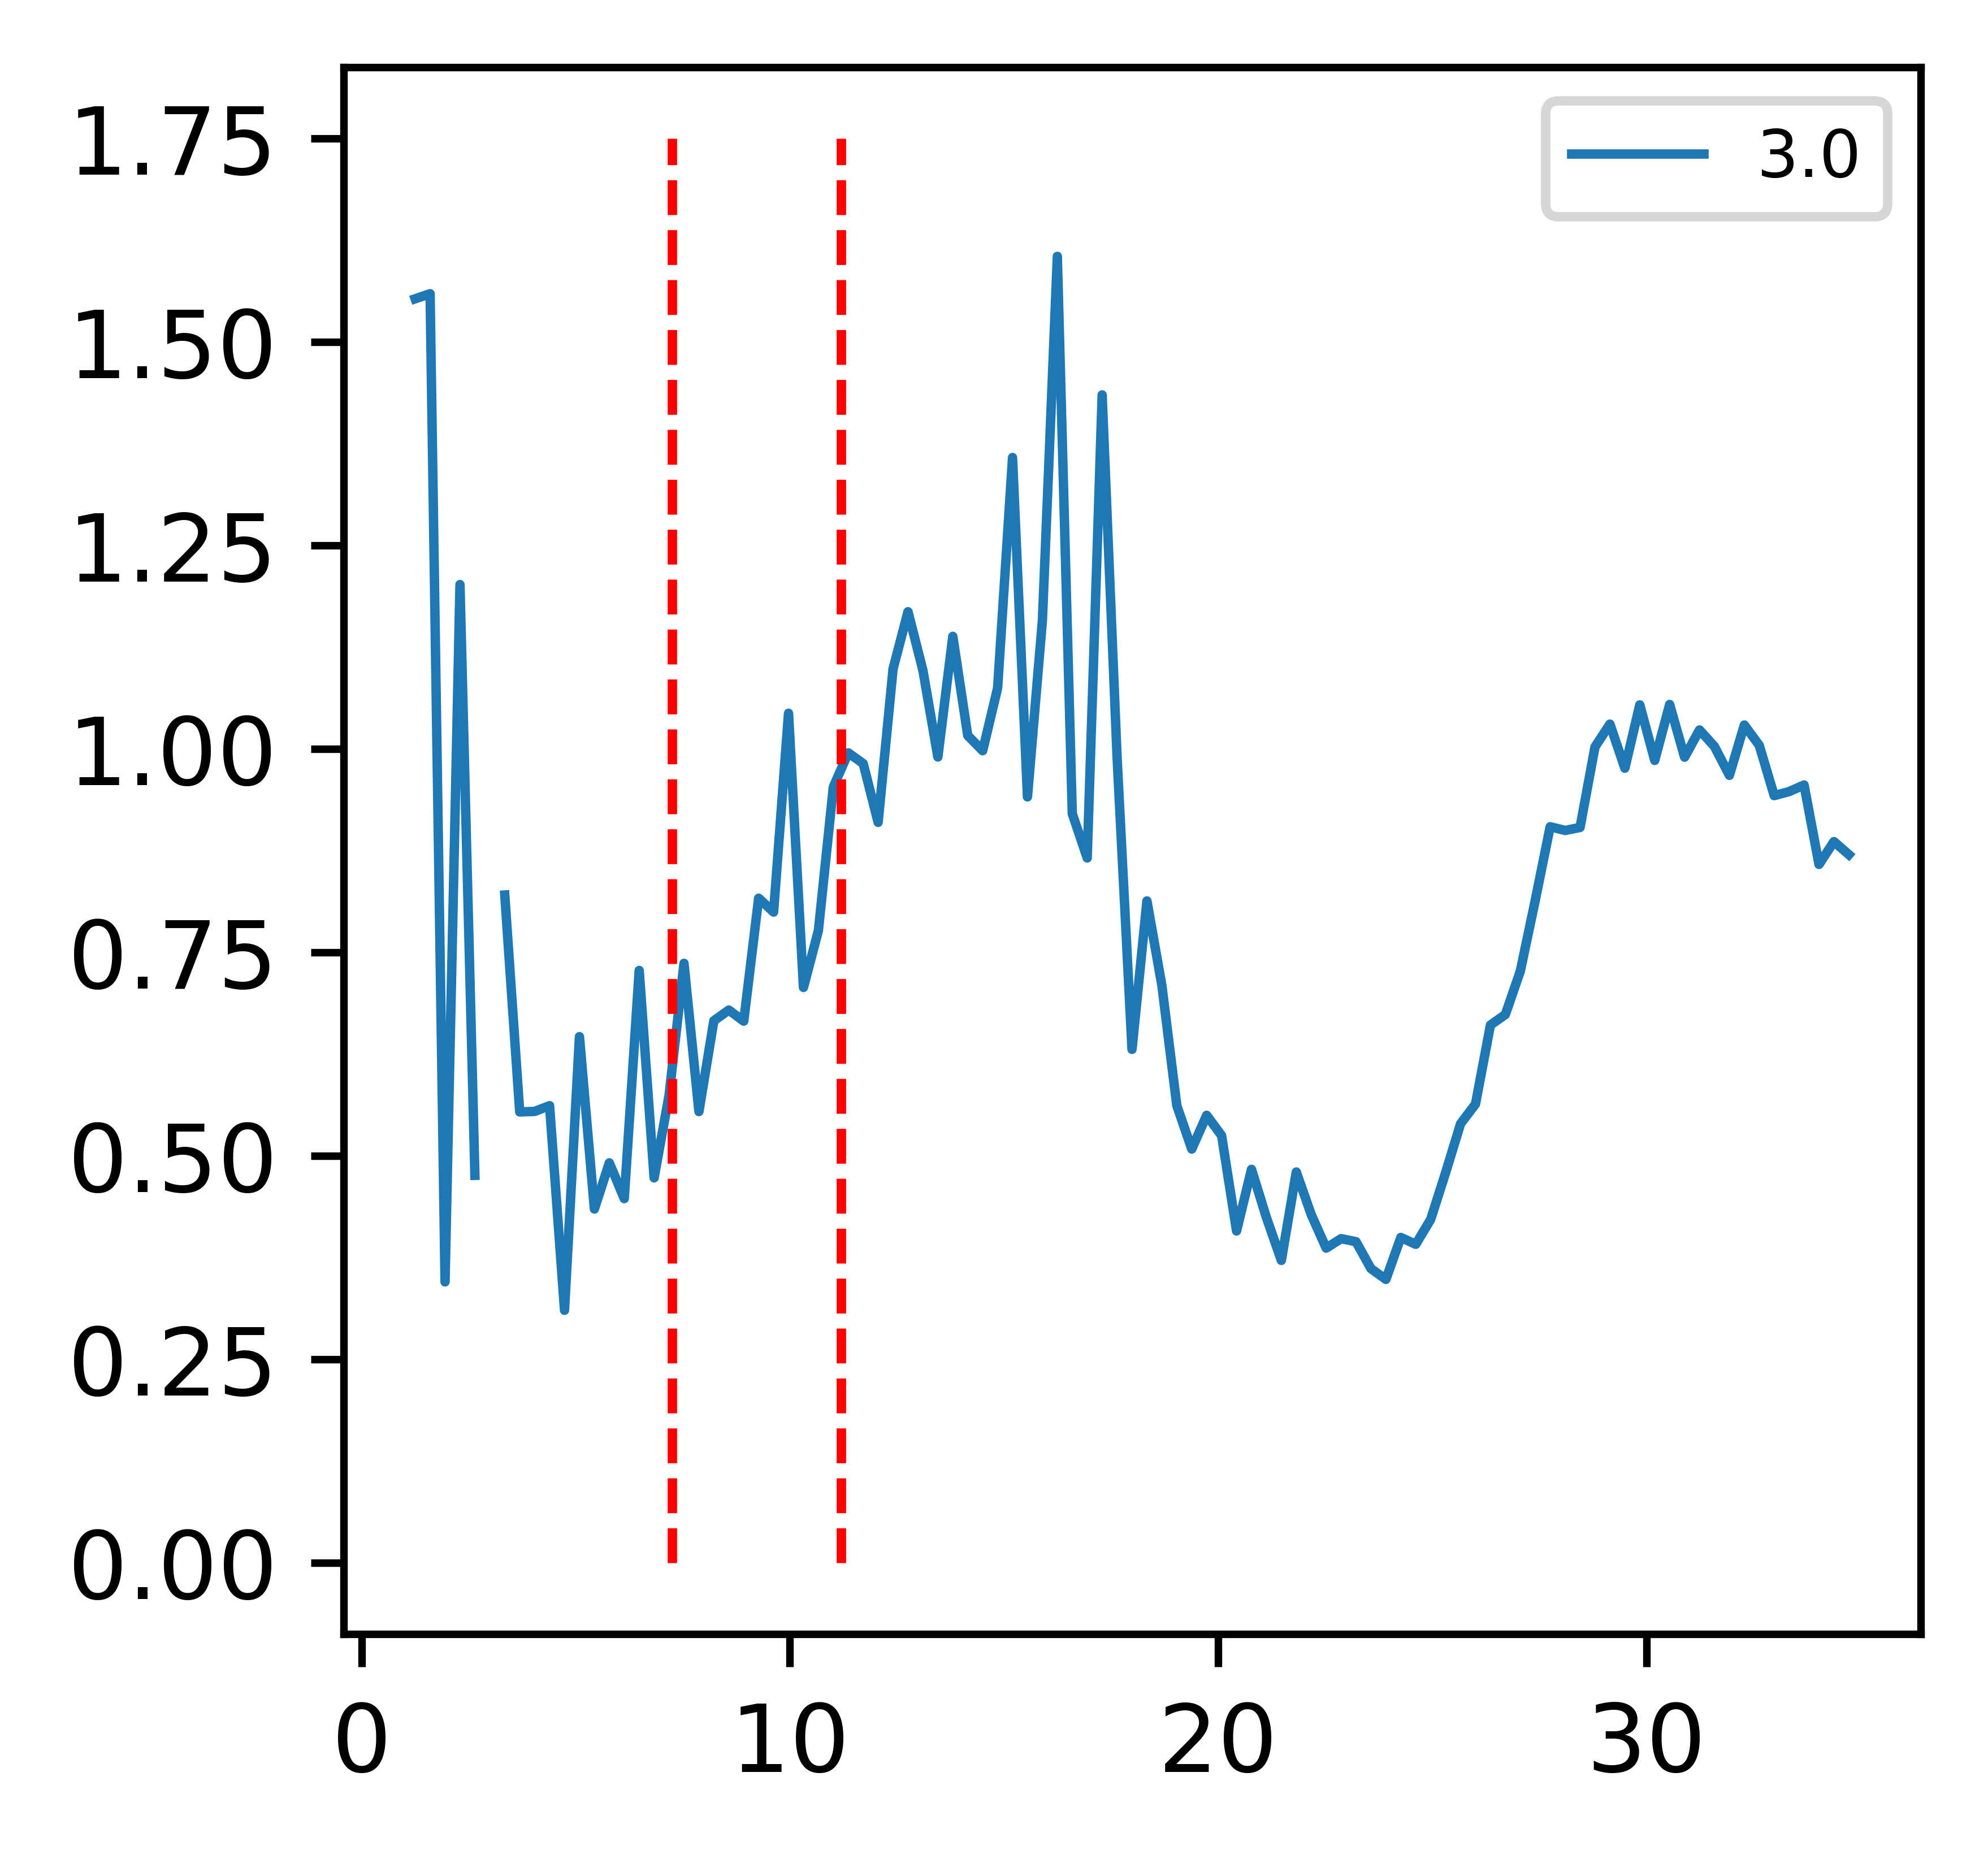

In [24]:
count = 0
fig = plt.figure()

for kT, jobs in project.find_jobs(job_filter).groupby("kT"):
    if kT < 2.4: continue
    for job in jobs:
        if job_id:
            if job.id != job_id:
                continue
        data = np.loadtxt(job.fn("cg_sf.txt"))
        wave_vectors = data[:,0]
        thetas = k_vector_to_2theta(wave_vectors, wave_length=0.15406)
        distances = k_vector_to_distance(wave_vectors)
        #plt.plot(data[:,0], data[:,1], label=kT)
        #plt.plot(thetas, data[:,1], label=kT)
        plt.plot(wave_vectors, data[:,1], label=kT)

plt.vlines(ymin=0, ymax=1.75, x=2*np.pi/0.561, linestyle="--", color="red")
plt.vlines(ymin=0, ymax=1.75, x=2*np.pi/0.867, linestyle="--", color="red")

plt.legend()
#plt.xlim(0, 1.2)

In [ ]:
for kT, jobs in project.find_jobs({"sigma_scale": 0.955}).groupby("kT"):
    if kT < 2.0: continue
    for job in jobs:
        fig = plt.figure()
        fpath = job.fn(f"cg-npt.gsd")
        sf = structure_factor(gsdfile=fpath, k_min=0.5, k_max=20, start=-10, stop=-1, ref_length=None)
        x = sf.bin_centers
        y = sf.S_k
        plt.plot(x, y, label=kT, c=colors[count])
        plt.title(f"kT: {kT}")
        plt.show()
        print()

In [ ]:
for kT, jobs in project.find_jobs({"sigma_scale": 0.955}).groupby("kT"):
    if kT < 2.0: continue
    for job in jobs:
        print(kT, job.path)

In [ ]:
for kT, jobs in project.find_jobs(
    {"doc.nvt_equilibrated": True,
     "sigma_scale": 0.955,
     "kT": 2.4,
     }).groupby("kT"):
    for job in jobs:
        #if not job.isfile("ua_structure_factor.txt"):
        fpath = job.fn(f"trajectory-nvt{job.doc.nvt_runs-1}.gsd")
        sf = structure_factor(gsdfile=fpath, k_min=0.5, k_max=30, start=-50, stop=-1, ref_distance=None)
        x = sf.bin_centers
        y = sf.S_k
        save_data = np.vstack([sf.bin_centers, sf.S_k]).T
        np.savetxt(job.fn("ua_structure_factor.txt"), save_data)
        #if not job.isfile("cg_structure_factor.txt"):
        cg_fpath = job.fn("cg-nvt.gsd")
        cg_sf = structure_factor(gsdfile=cg_fpath, k_min=0.5, k_max=30, start=-50, stop=-1, ref_distance=None)
        x = cg_sf.bin_centers
        y = cg_sf.S_k
        save_data = np.vstack([cg_sf.bin_centers, cg_sf.S_k]).T
        np.savetxt(job.fn("cg_structure_factor.txt"), save_data)
        #job.doc.sf_sampled = True

In [ ]:
plt.plot(sf.bin_centers, sf.S_k, label=kT)

In [ ]:
for kT, jobs in project.find_jobs({"doc.nvt_equilibrated": True, "sigma_scale": 0.955}).groupby("kT"):
    for job in jobs:
        fig = plt.figure()
        sf = np.loadtxt(job.fn("ua_structure_factor.txt"))
        plt.plot(sf[:,0], sf[:,1], label=kT)
        plt.legend()
        plt.show()

#plt.legend()
#plt.ylim(0, 4)
#plt.show()

# Diffraction Patterns:

In [ ]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    "kT": 3.0,
    "doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}
for job in project.find_jobs(filter=job_filter):
    print(job)

In [29]:
views = get_quaternions(n_views=12)

In [48]:
views = get_quaternions(n_views=30)

job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    "kT": 3.6,
    "doc.npt_equilibrated": True,
    "sigma_scale": 0.955
}

for job in project.find_jobs(filter=job_filter):
    print(job.path)
    dp = diffraction_pattern(
        gsdfile=job.fn("target_1monomer_per_bead.gsd"),
        ref_length=job.doc.ref_length,
        views=views,
        grid_size=512,
        start=-10,
        stop=-1,
    )

/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/ddff72030898e479189cd2df660938e3


<Axes: title={'center': 'Diffraction Pattern'}, xlabel='$k_x$', ylabel='$k_y$'>

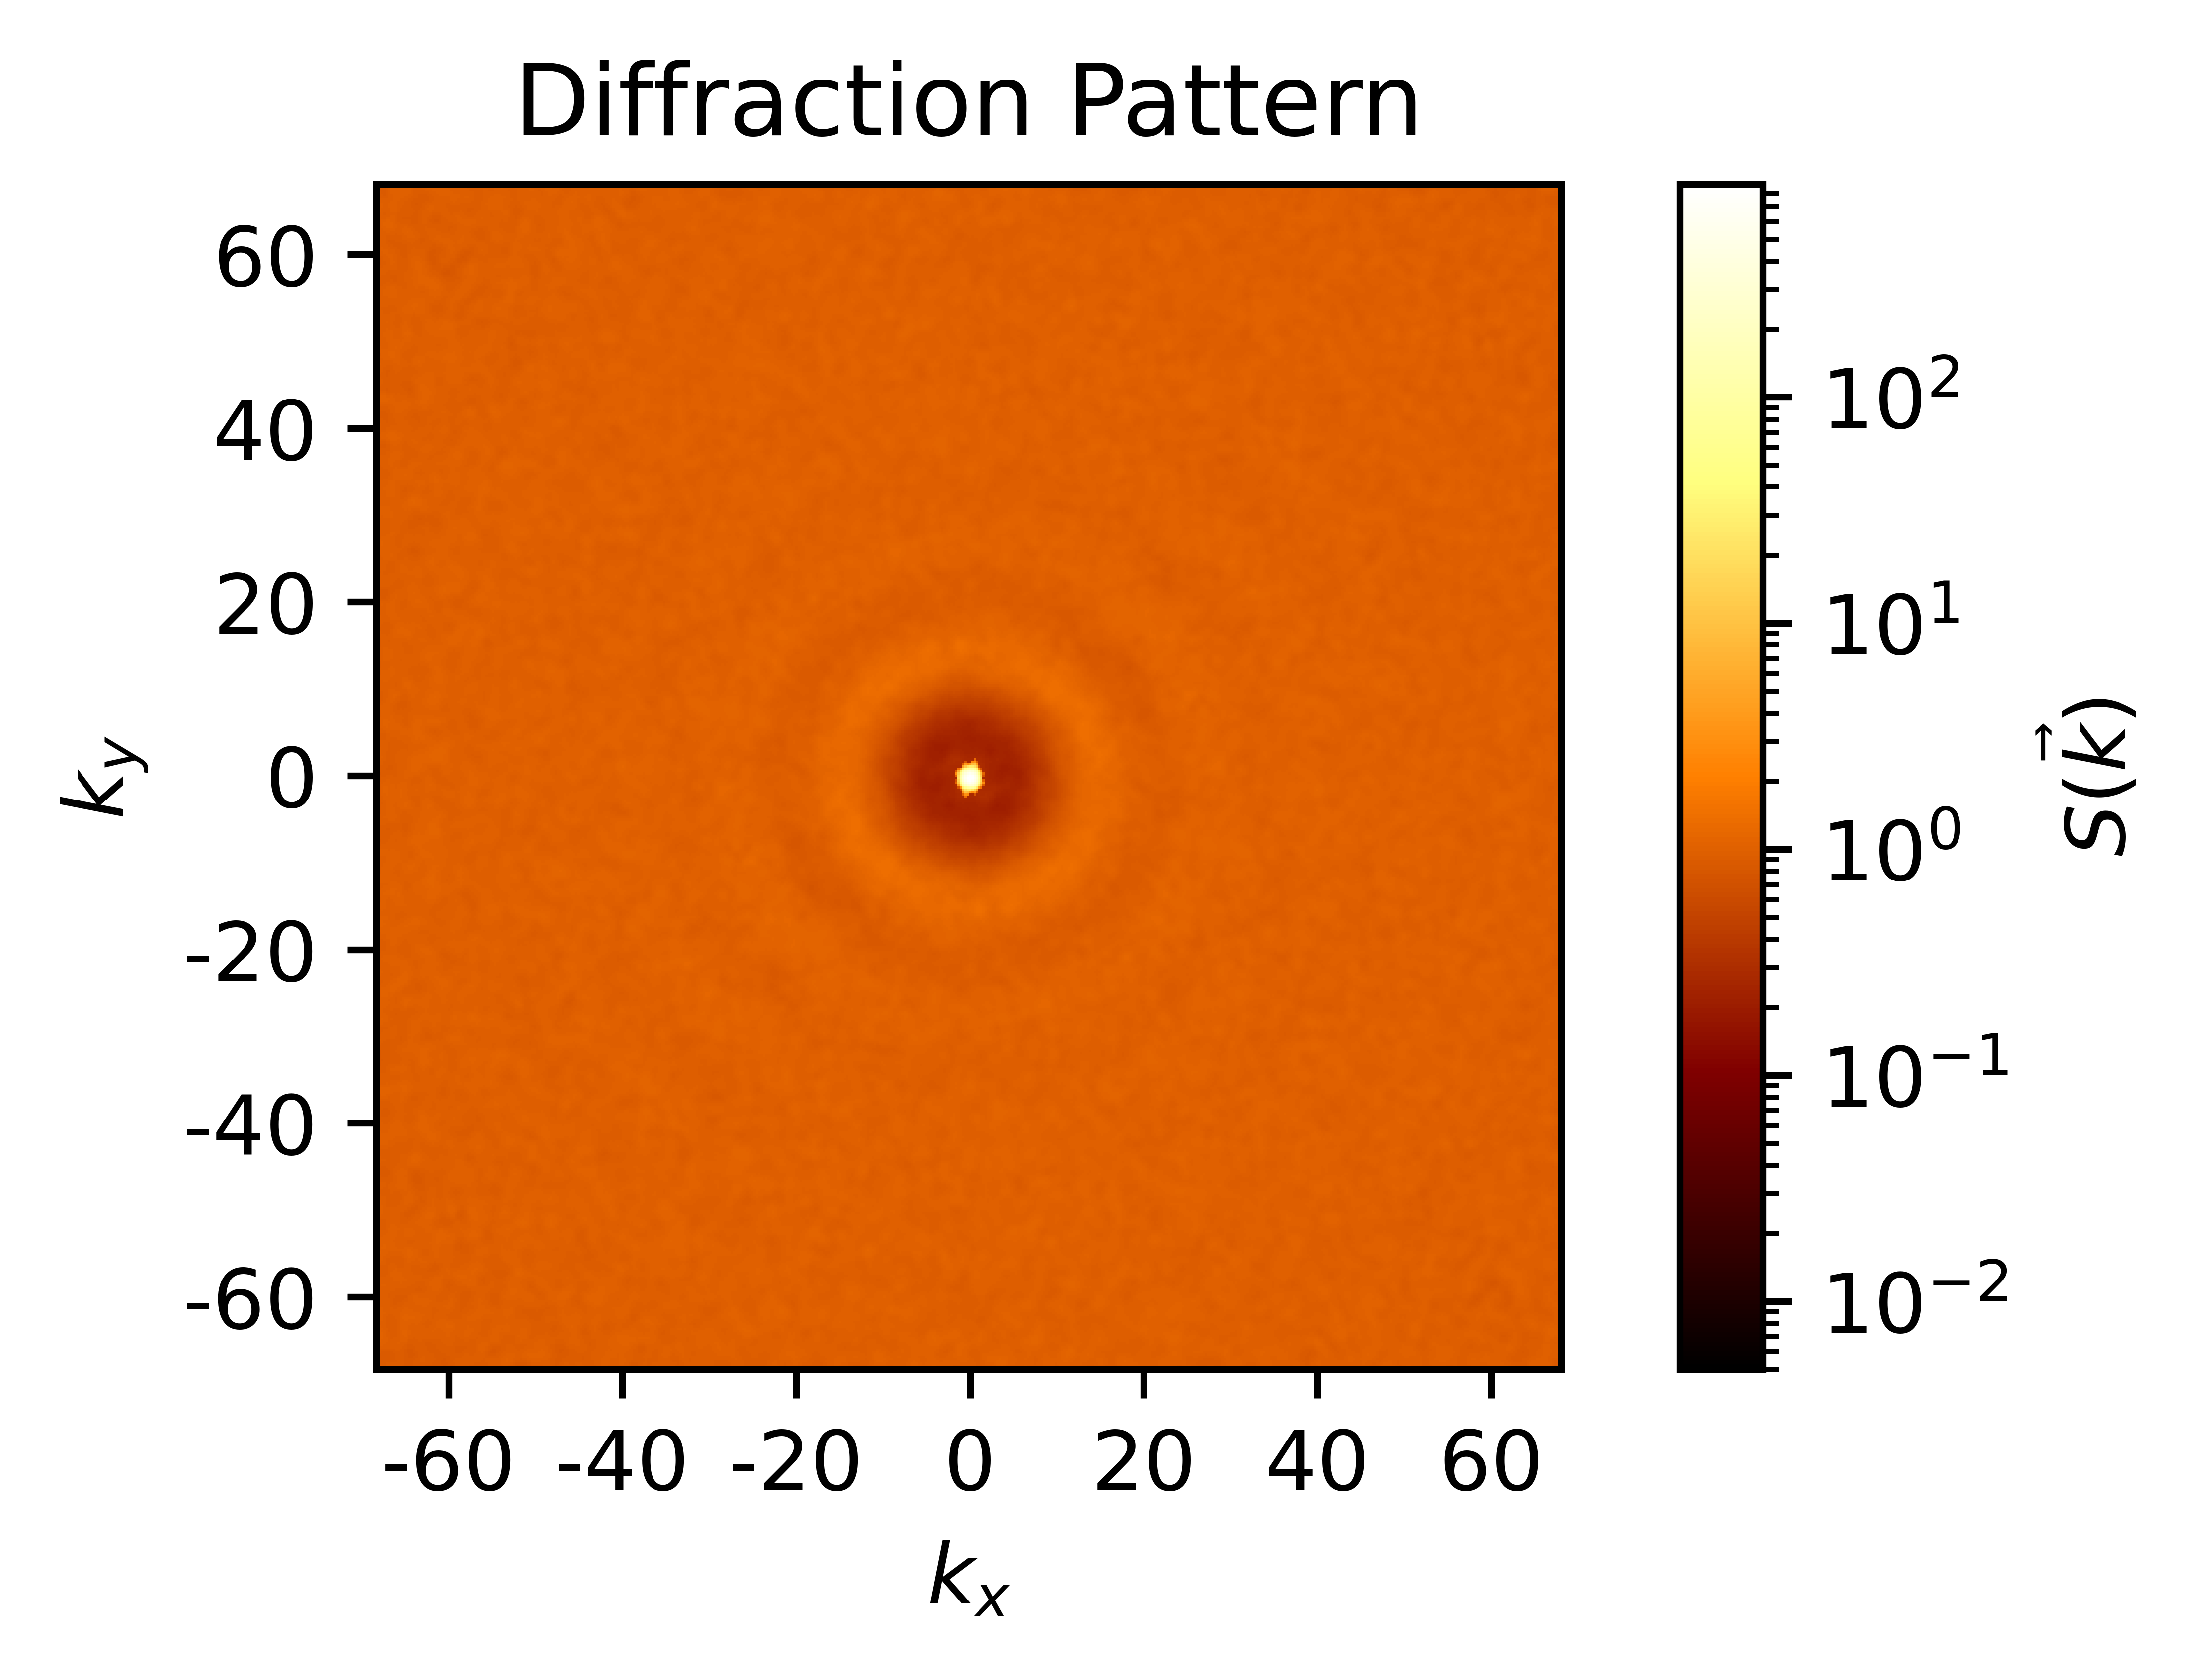

In [49]:
dp.plot()

In [ ]:
views = get_quaternions(n_views=4)

In [ ]:
run = 25

pic_count = 0

for i in range(1, 26):
    gsdfile = job.fn(f"trajectory-npt{i}.gsd")
    with gsd.hoomd.open(gsdfile) as traj:
        num_frames = len(traj)
        print(i, num_frames)
    for j in range(10, num_frames-10, 10):
        dp = diffraction_pattern(
            gsdfile=job.fn(f"trajectory-npt{i}.gsd"),
            views=[views[1]],
            start=j-10,
            stop=j
        )
        dp.plot().figure.savefig(f"images/dp{pic_count}.png")
        pic_count += 1

In [ ]:
dp.plot().figure.savefig("test.png")

In [ ]:
job.doc.npt_runs

In [ ]:
movie_maker(file_dir="images/", img_file_type="png", mov_file_name="pps_diff.mp4", framerate=80)